In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
GLOBAL_FLOAT_PRECISION_NUMPY = np.float64

In [3]:
torch.set_default_dtype(torch.float64)

## Data preparation

### Load data

In [4]:
chirp_direction = 'chirp_up'
data_file_path = r'C:\Users\vaish\dsvv_atomionics\compiled_data\compiled_' + f'{chirp_direction}.pkl'
data_cols = [
		'master_run_number', 'chirp_rate', 'fraction',
		'CA+_mean', 'CA+_std_dev', 'CA+_percentile_0', 'CA+_percentile_10', 'CA+_percentile_20', 
		'CA+_percentile_30', 'CA+_percentile_40', 'CA+_percentile_50', 'CA+_percentile_60', 'CA+_percentile_70', 
		'CA+_percentile_80', 'CA+_percentile_90', 'CA+_percentile_100', 'CA-_mean', 'CA-_std_dev', 'CA-_percentile_0', 
		'CA-_percentile_10', 'CA-_percentile_20', 'CA-_percentile_30', 'CA-_percentile_40', 'CA-_percentile_50', 
		'CA-_percentile_60', 'CA-_percentile_70', 'CA-_percentile_80', 'CA-_percentile_90', 'CA-_percentile_100'
	]

data = pd.DataFrame(pd.read_pickle(data_file_path), columns=data_cols, dtype=GLOBAL_FLOAT_PRECISION_NUMPY)
data = data.astype({'master_run_number': 'int32'})

# 80-20 train/test split
train_data_df = data.sample(frac=0.8, random_state=0)
test_data_df = data.drop(train_data_df.index)

print(train_data_df.shape)
print(train_data_df.head())
print(test_data_df.shape)
# print(test_data_df.head())

(63, 29)
    master_run_number  chirp_rate  fraction     CA+_mean  CA+_std_dev  \
49              15795  25094440.0  0.548201  4272.430706  2031.386231   
27              15795  25092480.0  0.558369  4270.678466  2043.572723   
30              15795  25096260.0  0.578843  4851.886235  1986.219204   
63              15795  25091500.0  0.645726  4291.362353  2035.944694   
45              15795  25093320.0  0.497269  4505.367316  2011.287619   

    CA+_percentile_0  CA+_percentile_10  CA+_percentile_20  CA+_percentile_30  \
49           -3165.0             1681.0             2582.0             3225.0   
27           -3458.0             1694.0             2571.0             3215.0   
30           -3417.0             2322.0             3183.0             3815.0   
63           -2894.0             1705.0             2622.0             3233.0   
45           -2498.0             1956.0             2845.0             3459.0   

    CA+_percentile_40  ...  CA-_percentile_10  CA-_percentile_20 

In [5]:
compiled_constants_csv_path = r'C:\Users\vaish\dsvv_atomionics\compiled_data\compiled_constants.csv'
compiled_constants_df = pd.read_csv(compiled_constants_csv_path)
compiled_constants_dtypes = {
	'master_run': 'int32',
	'chirp_direction': 'str',
	'bigT': GLOBAL_FLOAT_PRECISION_NUMPY,
	'Keff': GLOBAL_FLOAT_PRECISION_NUMPY,
	'contrast': GLOBAL_FLOAT_PRECISION_NUMPY,
	'g0': GLOBAL_FLOAT_PRECISION_NUMPY,
	'fringe_offset': GLOBAL_FLOAT_PRECISION_NUMPY
}
compiled_constants_df = compiled_constants_df.astype(compiled_constants_dtypes)

print(compiled_constants_df.shape)
print(compiled_constants_df.head())

(2, 7)
   master_run chirp_direction  bigT          Keff  contrast        g0  \
0       15795        chirp_up  0.01  1.610579e+07  0.077362  9.781717   
1       15795      chirp_down  0.01  1.610579e+07  0.071496 -9.785014   

   fringe_offset  
0        0.59805  
1        0.55894  


## Converting chirp rates to fractions

In [6]:
def sine(alpha, Keff, bigT, contrast, g0, fringe_offset):
    phi = (Keff * g0 - 2 * torch.pi * alpha) * (bigT**2)
    # # To check that we are getting the expected values for phi
    # phi_as_pi_multiples = phi / np.pi
    # print(f'phi: {phi_as_pi_multiples}')
    return (-contrast * torch.cos(phi) + fringe_offset)

In [7]:
def get_chirp_rates_from_noise(outputs, data_df):
	corrected_chirp_rates = outputs + torch.tensor(data_df['chirp_rate'].values).view(-1, 1)
	return corrected_chirp_rates

In [40]:
# shitty impromptu unit testing 
t1 = torch.tensor([[1], [2], [3]])
print(t1.shape)
t2 = pd.DataFrame([1, 2, 3], columns=['chirp_rate'])
print(t2)
t3 = get_chirp_rates_from_noise(t1, t2)
print(t3)

torch.Size([3, 1])
   chirp_rate
0           1
1           2
2           3
tensor([[2],
        [4],
        [6]])


In [9]:
def get_predicted_fractions_from_chirp_rates(chirp_rates, data_df):
	predicted_fractions = []
	for index in range(chirp_rates.shape[0]):
		data_row = data_df.iloc[index]
		master_run = data_row['master_run_number']
		compiled_constants_row = compiled_constants_df[(compiled_constants_df['master_run'] == master_run) & (compiled_constants_df['chirp_direction'] == chirp_direction)]

		Keff = compiled_constants_row['Keff'].item()
		bigT = compiled_constants_row['bigT'].item()
		contrast = compiled_constants_row['contrast'].item()
		g0 = compiled_constants_row['g0'].item()
		fringe_offset = compiled_constants_row['fringe_offset'].item()
		alpha = chirp_rates[index]
		predicted_fraction = sine(alpha, Keff, bigT, contrast, g0, fringe_offset)
		predicted_fractions.append(predicted_fraction)
	
	predicted_fractions_tensor = torch.stack(predicted_fractions, 0)
	return predicted_fractions_tensor


In [10]:
# shitty impromptu unit testing
master_run = 15795
t1 = torch.tensor([[1], [2], [3]])
print(t1.shape)
for i in range(1,4):
	compiled_constants_row = compiled_constants_df[(compiled_constants_df['master_run'] == master_run) & (compiled_constants_df['chirp_direction'] == chirp_direction)]
	Keff = compiled_constants_row['Keff'].item()
	bigT = compiled_constants_row['bigT'].item()
	contrast = compiled_constants_row['contrast'].item()
	g0 = compiled_constants_row['g0'].item()
	fringe_offset = compiled_constants_row['fringe_offset'].item()
	print(Keff, bigT, contrast, g0, fringe_offset)
	alpha = torch.tensor(i)
	predicted_fraction = sine(alpha, Keff, bigT, contrast, g0, fringe_offset)
	print(f'{alpha}: {predicted_fraction}')

print(f'\n\n')
t2 = get_predicted_fractions_from_chirp_rates(t1, data)
print(f'{t2[0].item():.18f}')
print(f'{t2[1].item():.18f}')
print(f'{t2[2].item():.18f}')

torch.Size([3, 1])
16105786.351132 0.01 0.077362 9.781717 0.59805
1: 0.6483259365980047
16105786.351132 0.01 0.077362 9.781717 0.59805
2: 0.6482889827797012
16105786.351132 0.01 0.077362 9.781717 0.59805
3: 0.6482520091278429



0.648325936598004748
0.648288982779701151
0.648252009127842865


In [11]:
# A little test you can run, to verify that gradients do propagate through this transformation
# https://stackoverflow.com/questions/70426391/how-to-transform-output-of-nn-while-still-being-able-to-train

# start with some random tensor representing the input predictions
# make sure it requires_grad
pred = torch.tensor([[1.0],[1.0],[2.0],[2.0],[10.0],[10.0]]).requires_grad_(True)
print(pred.shape)
# transform it
tpred = get_predicted_fractions_from_chirp_rates(pred, train_data_df)
print(tpred.shape)
# make up some "default" loss function and back-prop
tpred.mean().backward()

# check to see all gradients of the original prediction:
pred.grad

torch.Size([6, 1])
torch.Size([6, 1])


tensor([[-6.1573e-06],
        [-6.1573e-06],
        [-6.1606e-06],
        [-6.1606e-06],
        [-6.1870e-06],
        [-6.1870e-06]])

In [12]:
# A little test you can run, to verify that gradients do propagate through this transformation
# https://stackoverflow.com/questions/70426391/how-to-transform-output-of-nn-while-still-being-able-to-train

# start with some random tensor representing the input predictions
# make sure it requires_grad
pred = torch.rand((63, 1)).requires_grad_(True)
print(pred.shape)
# transform it
tpred = get_chirp_rates_from_noise(pred, train_data_df)
print(tpred.shape)
# make up some "default" loss function and back-prop
tpred.mean().backward()

# check to see all gradients of the original prediction:
pred.grad

torch.Size([63, 1])
torch.Size([63, 1])


tensor([[0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0.0159],
        [0

## MSLE Loss

In [13]:
def MSLELoss(pred, target):
    return torch.mean((torch.log1p(pred) - torch.log1p(target)) ** 2)

## Benchmark MSE score

In [14]:
test_chirp_rates = torch.tensor(test_data_df['chirp_rate'].values).view(-1, 1)
test_fractions = torch.tensor(test_data_df['fraction'].values).view(-1, 1)

In [15]:
print(test_chirp_rates.shape)

torch.Size([16, 1])


In [16]:
def get_baseline_score(predicted_tensor, target_tensor, loss_fn):
	loss = loss_fn(predicted_tensor, target_tensor)
	return loss.item()

In [17]:
predicted_fractions_tensor = get_predicted_fractions_from_chirp_rates(test_chirp_rates, test_data_df)

MSELoss = nn.MSELoss()
mse_baseline_score = get_baseline_score(predicted_fractions_tensor, test_fractions, MSELoss)
print(f'MSE baseline score: {mse_baseline_score}')

msle_baseline_score = get_baseline_score(predicted_fractions_tensor, test_fractions, MSLELoss)
print(f'MSLE baseline score: {msle_baseline_score}')

MSE baseline score: 0.00830978710839569
MSLE baseline score: 0.003451160028686132


## Training

### Neural Network

In [41]:
class TransformationNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(TransformationNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, output_dim)
        
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = self.fc4(x)
        return x

In [42]:
# select columns chirp_rate, CA+_mean, CA+_std_dev, CA-_mean, CA-_std_dev
training_data_tensor = torch.tensor(train_data_df[['CA+_mean', 'CA+_std_dev','CA+_percentile_0', 'CA+_percentile_100', 'CA-_mean', 'CA-_std_dev', 'CA-_percentile_0', 'CA-_percentile_100']].values)
observed_fractions_tensor = torch.tensor(train_data_df['fraction'].values).view(-1, 1)

In [43]:
model = TransformationNN(input_dim=8, output_dim=1)
optimizer = optim.Adam(model.parameters(), lr=0.9)
MSELoss = nn.MSELoss()
HuberLoss = nn.SmoothL1Loss()

In [46]:
def train(model, optimizer, loss_fn, epochs, training_data_tensor, observed_fractions_tensor):
	loss_values = []
	for epoch in range(epochs):
		model.train()

		# Forward pass: Compute predicted y by passing x to the model
		noise_corrections = model(training_data_tensor)
		print(noise_corrections[0])
		chirp_rates = get_chirp_rates_from_noise(noise_corrections, train_data_df)
		predicted_fractions_tensor = get_predicted_fractions_from_chirp_rates(chirp_rates, train_data_df)
		loss = loss_fn(predicted_fractions_tensor, observed_fractions_tensor)
		loss_values.append(loss.item())

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		if epoch % (epochs / 10) == 0:
			print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item()}')
			print(f'noise corrections variation: {torch.var(noise_corrections)}')
	
	plt.figure(figsize=(10, 6))
	plt.plot(range(epochs), loss_values, label='Training Loss')
	plt.xlabel('Epochs')
	plt.ylabel('Loss')
	plt.title('Training Loss vs. Epochs')
	plt.legend()
	plt.show()


In [47]:
train(model, optimizer, MSELoss, 600, training_data_tensor, observed_fractions_tensor)

tensor([274.9543], grad_fn=<SelectBackward0>)
Epoch [1/600], Loss: 0.004537606650085159
noise corrections variation: 3.283289981781801e-27
tensor([274.9510], grad_fn=<SelectBackward0>)
tensor([274.9485], grad_fn=<SelectBackward0>)
tensor([274.9471], grad_fn=<SelectBackward0>)
tensor([274.9468], grad_fn=<SelectBackward0>)
tensor([274.9476], grad_fn=<SelectBackward0>)
tensor([274.9492], grad_fn=<SelectBackward0>)
tensor([274.9514], grad_fn=<SelectBackward0>)
tensor([274.9538], grad_fn=<SelectBackward0>)
tensor([274.9560], grad_fn=<SelectBackward0>)
tensor([274.9578], grad_fn=<SelectBackward0>)
tensor([274.9589], grad_fn=<SelectBackward0>)
tensor([274.9592], grad_fn=<SelectBackward0>)
tensor([274.9588], grad_fn=<SelectBackward0>)
tensor([274.9578], grad_fn=<SelectBackward0>)
tensor([274.9564], grad_fn=<SelectBackward0>)
tensor([274.9548], grad_fn=<SelectBackward0>)
tensor([274.9533], grad_fn=<SelectBackward0>)
tensor([274.9521], grad_fn=<SelectBackward0>)
tensor([274.9513], grad_fn=<Selec

KeyboardInterrupt: 

## Evaluation

In [ ]:
def get_model_score(predicted_tensor, target_tensor, loss_fn):
	loss = loss_fn(predicted_tensor, target_tensor)
	return loss.item()

In [ ]:
test__noise_tensor = torch.tensor(test_data_df[['CA+_mean', 'CA+_std_dev','CA+_percentile_0', 'CA+_percentile_100', 'CA-_mean', 'CA-_std_dev', 'CA-_percentile_0', 'CA-_percentile_100']].values)

# Set model to evaluation mode
model.eval()

# Forward pass through the model
with torch.no_grad():
    noise_corrections = model(test__noise_tensor)
    chirp_rates = get_chirp_rates_from_noise(noise_corrections, test_data_df)
    predicted_fractions = get_predicted_fractions_from_chirp_rates(chirp_rates, test_data_df)

test_fractions_shape_corrected = test_fractions.view(-1, 1)
mse_model_score = get_model_score(predicted_fractions, test_fractions_shape_corrected, MSELoss)
print(f'MSE model score: {mse_model_score}')

msle_model_score = get_model_score(predicted_fractions, test_fractions_shape_corrected, MSLELoss)
print(f'MSLE model score: {msle_model_score}')

MSE model score: 0.006713347995702129
MSLE model score: 0.0028007717806742185


In [ ]:
# given a master_un and chirp_direction plot the predicted fraction vs the actual fraction
def plot_predicted_vs_actual(master_run_number):
	master_run_data = data[data['master_run_number'] == master_run_number]
	chirp_rates_original = torch.tensor(master_run_data['chirp_rate'].values)
	observed_fractions = master_run_data['fraction'].values

	expected_fractions_with_original_chirp_rates = get_predicted_fractions_from_chirp_rates(torch.tensor(chirp_rates_original), master_run_data)

	model.eval()
	with torch.no_grad():
		noise_corrections = model(torch.tensor(master_run_data[['CA+_mean', 'CA+_std_dev','CA+_percentile_0', 'CA+_percentile_100', 'CA-_mean', 'CA-_std_dev', 'CA-_percentile_0', 'CA-_percentile_100']].values))
		corrected_chirp_rates = get_chirp_rates_from_noise(noise_corrections, master_run_data)
		expected_fractions_with_corrected_chirp_rates = get_predicted_fractions_from_chirp_rates(corrected_chirp_rates, master_run_data)
	
	plt.figure(figsize=(10, 6))
	plt.scatter(chirp_rates_original, observed_fractions, label='Observed Fractions')
	plt.scatter(chirp_rates_original, expected_fractions_with_original_chirp_rates, label='Predicted Fractions with Original Chirp Rates')
	plt.show()

	print(corrected_chirp_rates)
	plt.scatter(corrected_chirp_rates, observed_fractions, label='Observed Fractions')
	plt.scatter(corrected_chirp_rates, expected_fractions_with_corrected_chirp_rates, label='Predicted Fractions with Corrected Chirp Rates')
	plt.show()

C:\Users\vaish\AppData\Local\Temp\ipykernel_1216\1899466795.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expected_fractions_with_original_chirp_rates = get_predicted_fractions_from_chirp_rates(torch.tensor(chirp_rates_original), master_run_data)


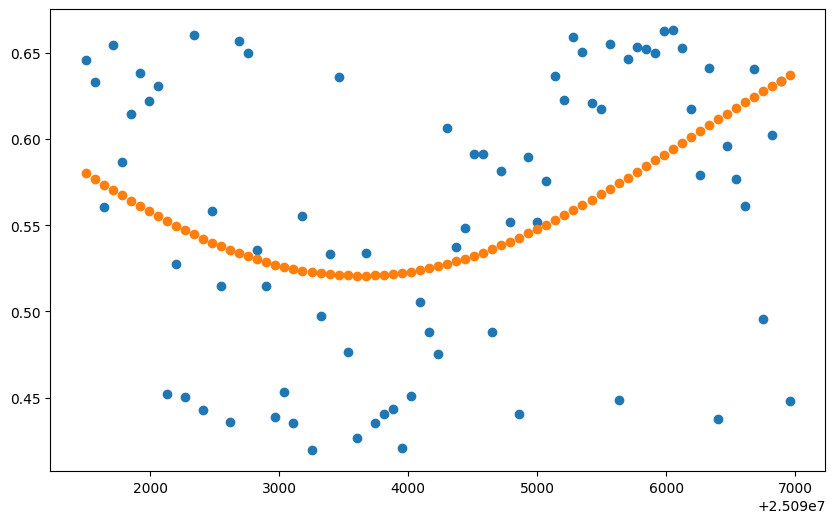

tensor([[25093077.6465],
        [25095807.6465],
        [25092447.6465],
        [25091257.6465],
        [25095947.6465],
        [25096087.6465],
        [25091887.6465],
        [25092377.6465],
        [25093217.6465],
        [25094057.6465],
        [25095317.6465],
        [25094267.6465],
        [25095667.6465],
        [25093567.6465],
        [25094127.6465],
        [25095247.6465],
        [25095107.6465],
        [25092167.6465],
        [25093987.6465],
        [25093287.6465],
        [25096017.6465],
        [25095457.6465],
        [25092587.6465],
        [25091187.6465],
        [25095527.6465],
        [25092937.6465],
        [25095177.6465],
        [25091817.6465],
        [25094827.6465],
        [25093497.6465],
        [25095597.6465],
        [25094477.6465],
        [25091747.6465],
        [25091607.6465],
        [25094547.6465],
        [25092517.6465],
        [25094197.6465],
        [25094967.6465],
        [25091537.6465],
        [25093917.6465],


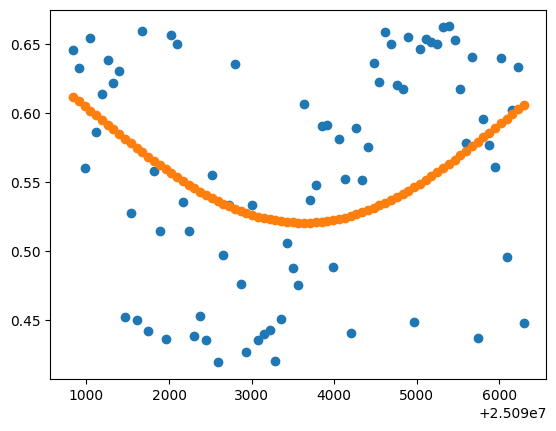

In [ ]:
plot_predicted_vs_actual(15795)